In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# If you need to import from a local utils.py, uncomment and adjust the following lines:
import sys
import os
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
# Construct the full path to the folder
folder_path = r'C:\Users\Petrb\Desktop\DTU\3rdSemester\02477_BAYESIAN_MACHINE_LEARNING'

# Add the folder to the Python path
sys.path.append(folder_path)

# Now you can import the utils module
from utils import *
from kernel_gaussian_classes import * 



In [8]:
# Generate some synthetic data
def generate_data():
    # True function: f(x) = sin(3x) + 0.3*cos(9x)
    def f(x):
        return jnp.sin(3*x) + 0.3*jnp.cos(9*x)
    
    # Create training data with noise
    X_train = jnp.linspace(-3, 3, 20).reshape(-1, 1)  # 20 points in [-3, 3]
    y_train = f(X_train) + 0.1 * np.random.normal(size=(20, 1))  # Add noise
    
    # Create test points for prediction
    X_test = jnp.linspace(-4, 4, 100).reshape(-1, 1)
    
    return X_train, y_train, X_test, f

In [9]:
# Function to generate samples (assumed to be defined elsewhere)
def generate_samples(key, mu, Sigma, num_samples):
    # Simple implementation (not the most efficient)
    L = jnp.linalg.cholesky(Sigma + 1e-8 * jnp.eye(len(mu)))
    samples = mu + L @ np.random.normal(key, shape=(len(mu), num_samples))
    return samples

In [10]:
# Generate data
X_train, y_train, X_test, true_f = generate_data()

In [11]:
# Initialize kernel and GP
kernel = StationaryIsotropicKernel(squared_exponential, kappa=1.0, lengthscale=0.5)
gp = GaussianProcessRegression(X_train, y_train, kernel, kappa=1.0, lengthscale=0.5, sigma=0.1)
    

In [12]:
mu_f, Sigma_f = gp.predict_f(X_test)

In [13]:
mu_y, Sigma_y = gp.predict_y(X_test)

In [14]:
from jax import random
# Make sure cell 0 has been run to import 'random' from jax
key = random.PRNGKey(42)
samples = gp.posterior_samples(key, X_test, 10)

The shape of z's: (100, 10)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)


In [15]:
# 4. Compute marginal likelihood
log_ml = gp.log_marginal_likelihood(1.0, 0.5, 0.1)
print(f"Log marginal likelihood: {log_ml}")

Log marginal likelihood: -41.112667083740234


The shape of z's: (100, 10)
Shape of the mean, mu (100, 1)
Shape of mu after broadcasting (100, 1)
Shape of L: (100, 100)
Shape of f_samples (100, 10)


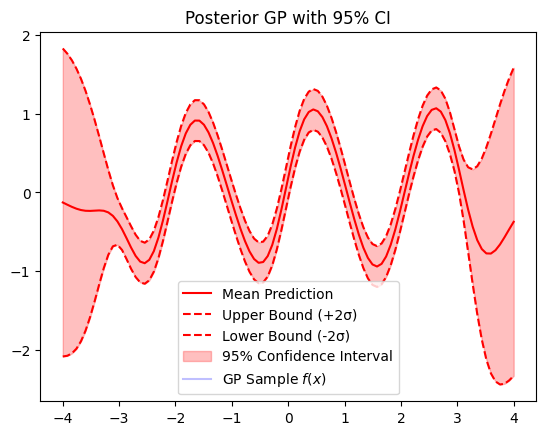

In [18]:
def plot_with_uncertainty(ax, Xp, gp, color='r', color_samples='b', title="", num_samples=0, seed=0):
    """
    Plot the predictive mean and uncertainty (confidence interval) from a Gaussian Process (GP).
    
    This function visualizes the mean prediction, confidence intervals, and optionally samples from the GP posterior.
    
    Arguments:
        ax            -- Matplotlib axis where the plot will be drawn.
        Xp            -- Input points where the GP is evaluated (shape NxD).
        gp            -- Trained Gaussian Process model.
        color         -- Color for the mean and confidence interval (default: red).
        color_samples -- Color for the sampled functions (default: blue).
        title         -- Title of the plot (default: empty string).
        num_samples   -- Number of function samples to draw from the posterior (default: 0, meaning no samples drawn).
        seed          -- Random seed for reproducibility (default: 0).
    """
    # Predict the mean and covariance from the GP at the given test points Xp
    mu, Sigma = gp.predict_y(Xp)
    mean = mu.ravel()  # Flatten mean vector
    std = jnp.sqrt(jnp.diag(Sigma))  # Extract standard deviation from the diagonal of the covariance matrix
    
    # Generate a random seed for sampling
    key = random.PRNGKey(seed)

    # Plot the predictive mean
    ax.plot(Xp, mean, color=color, label='Mean Prediction')
    
    # Plot confidence interval (±2 standard deviations for ~95% confidence)
    ax.plot(Xp, mean + 2*std, color=color, linestyle='--', label='Upper Bound (+2σ)')
    ax.plot(Xp, mean - 2*std, color=color, linestyle='--', label='Lower Bound (-2σ)')
    ax.fill_between(Xp.ravel(), mean - 2*std, mean + 2*std, color=color, alpha=0.25, label='95% Confidence Interval')
    
    # Draw posterior samples if requested
    if num_samples > 0:
        fs = gp.posterior_samples(key, Xp, num_samples)  # Sample from the GP posterior
        ax.plot(Xp, fs[:, 0], color=color_samples, alpha=0.25, label="GP Sample $f(x)$")
        ax.plot(Xp, fs[:, 1:], color=color_samples, alpha=0.25)
    
    # Set the title of the plot
    ax.set_title(title)
    ax.legend()
    
    
# make the plot 
plot_with_uncertainty(plt.gca(), X_test, gp, color='r', color_samples='b', title="Posterior GP with 95% CI", num_samples=10, seed=0)


In [21]:
# Compute posterior at x* = 1
x_star = jnp.array([[1.0]])  # Shape: (1, 1)
mu_f_star, Sigma_f_star = gp.predict_f(x_star)

In [22]:
# Extract scalar values (since we only have one test point)
mean_f_star = mu_f_star[0, 0]
var_f_star = Sigma_f_star[0, 0]

print(f"p(f*|y, x*=1) = N({mean_f_star:.4f}, {var_f_star:.4f})")

p(f*|y, x*=1) = N(0.1172, 0.0069)


In [25]:
from jax import grad, jit
import jax.numpy as jnp
from scipy.optimize import minimize
def optimize_hyperparameters(gp_model):
    # Define negative log marginal likelihood (to minimize)
    def objective(params):
        kappa, lengthscale, sigma = jnp.exp(params)  # Ensure positivity
        return -gp_model.log_marginal_likelihood(kappa, lengthscale, sigma)
    
    # Initial values (log space to enforce positivity)
    initial_params = jnp.log(jnp.array([gp_model.kappa, gp_model.lengthscale, gp_model.sigma]))
    
    # Optimize
    result = minimize(objective, initial_params, method='L-BFGS-B')
    
    # Extract optimized parameters
    opt_params = jnp.exp(result.x)
    print(f"Optimized hyperparameters: kappa={opt_params[0]:.3f}, lengthscale={opt_params[1]:.3f}, sigma={opt_params[2]:.3f}")
    
    # Update model with optimized parameters
    gp_model.set_hyperparameters(opt_params[0], opt_params[1], opt_params[2])
    
    return opt_params

In [26]:
optimize_hyperparameters(gp)

Optimized hyperparameters: kappa=1.000, lengthscale=0.578, sigma=0.293


Array([1.       , 0.5775703, 0.293312 ], dtype=float32)